In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Carregamento do dataframe

In [42]:
df = pd.read_csv('data.csv')
df.head()

,id,sender_id,type_name,timestamp,intent_name,action_name,data
0,1,5ef090cb-cf75-425f-a23c-baa8769811b2,action,1.618616e+09,NaN,action_session_start,"{""event"": ""action"", ""timestamp"": 1618616140.48..."
1,2,5ef090cb-cf75-425f-a23c-baa8769811b2,session_started,1.618616e+09,NaN,NaN,"{""event"": ""session_started"", ""timestamp"": 1618..."
2,3,5ef090cb-cf75-425f-a23c-baa8769811b2,action,1.618616e+09,NaN,action_listen,"{""event"": ""action"", ""timestamp"": 1618616140.48..."
3,4,5ef090cb-cf75-425f-a23c-baa8769811b2,user,1.618616e+09,saudacao,NaN,"{""event"": ""user"", ""timestamp"": 1618616140.8380..."
4,5,5ef090cb-cf75-425f-a23c-baa8769811b2,user_featurization,1.618616e+09,NaN,NaN,"{""event"": ""user_featurization"", ""timestamp"": 1..."


In [43]:
#Converte os dados na coluna 'data' (em json) para colunas no dataframe
df = pd.concat([df, pd.io.json.json_normalize(df.data.apply(json.loads))], axis=1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,id,sender_id,type_name,timestamp,intent_name,action_name,data,event,timestamp,name,policy,confidence,action_text,text,input_channel,message_id,parse_data.intent.id,parse_data.intent.name,parse_data.intent.confidence,parse_data.entities,parse_data.text,parse_data.message_id,parse_data.intent_ranking,parse_data.response_selector.all_retrieval_intents,parse_data.response_selector.default.response.id,parse_data.response_selector.default.response.responses,parse_data.response_selector.default.response.response_templates,parse_data.response_selector.default.response.confidence,parse_data.response_selector.default.response.intent_response_key,parse_data.response_selector.default.response.utter_action,parse_data.response_selector.default.response.template_name,parse_data.response_selector.default.ranking,use_text_for_featurization,metadata.utter_action,data.elements,data.quick_replies,data.buttons,data.attachment,data.image,data.custom,value
0,1,5ef090cb-cf75-425f-a23c-baa8769811b2,action,1.618616e+09,NaN,action_session_start,"{""event"": ""action"", ""timestamp"": 1618616140.48...",action,1.618616e+09,action_session_start,None,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5ef090cb-cf75-425f-a23c-baa8769811b2,session_started,1.618616e+09,NaN,NaN,"{""event"": ""session_started"", ""timestamp"": 1618...",session_started,1.618616e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5ef090cb-cf75-425f-a23c-baa8769811b2,action,1.618616e+09,NaN,action_listen,"{""event"": ""action"", ""timestamp"": 1618616140.48...",action,1.618616e+09,action_listen,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,5ef090cb-cf75-425f-a23c-baa8769811b2,user,1.618616e+09,saudacao,NaN,"{""event"": ""user"", ""timestamp"": 1618616140.8380...",user,1.618616e+09,NaN,NaN,NaN,NaN,oi,rest,e6785e9a148c4f5bac2234a8c6e791e6,1.117066e+18,saudacao,0.999581,[],oi,e6785e9a148c4f5bac2234a8c6e791e6,"[{'id': 1117065996515008408, 'name': 'saudacao...",[],NaN,NaN,NaN,0.0,NaN,utter_None,utter_None,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5ef090cb-cf75-425f-a23c-baa8769811b2,user_featurization,1.618616e+09,NaN,NaN,"{""event"": ""user_featurization"", ""timestamp"": 1...",user_featurization,1.618616e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df.describe()

,id,timestamp,timestamp,confidence,action_text,parse_data.intent.id,parse_data.intent.confidence,parse_data.response_selector.default.response.id,parse_data.response_selector.default.response.responses,parse_data.response_selector.default.response.response_templates,parse_data.response_selector.default.response.confidence,parse_data.response_selector.default.response.intent_response_key,data.elements,data.quick_replies,data.attachment,data.image,data.custom
count,606.00000,6.060000e+02,6.060000e+02,207.000000,0.0,6.200000e+01,81.000000,0.0,0.0,0.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,303.50000,1.618726e+09,1.618726e+09,0.917934,NaN,-9.969229e+17,0.948977,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
std,175.08141,4.210998e+04,4.210998e+04,0.181443,NaN,4.553892e+18,0.146572,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,1.00000,1.618616e+09,1.618616e+09,0.300000,NaN,-8.306835e+18,0.359421,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,152.25000,1.618687e+09,1.618687e+09,0.934246,NaN,-5.104035e+18,0.990514,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,303.50000,1.618746e+09,1.618746e+09,0.997410,NaN,-5.292040e+17,0.998779,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,454.75000,1.618763e+09,1.618763e+09,1.000000,NaN,3.102981e+18,0.999895,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
max,606.00000,1.618763e+09,1.618763e+09,1.000000,NaN,8.477700e+18,1.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df.intent_name.value_counts()

agendar_atendimento    17
ajuda                  13
alvara_sanitario       10
confirmacao             9
consultar_iptu          8
ligar_eletricidade      7
saudacao                7
nlu_fallback            6
despedida               3
negacao                 1
Name: intent_name, dtype: int64

# Métricas

## Verificação das intenções mais chamadas pelos usuários

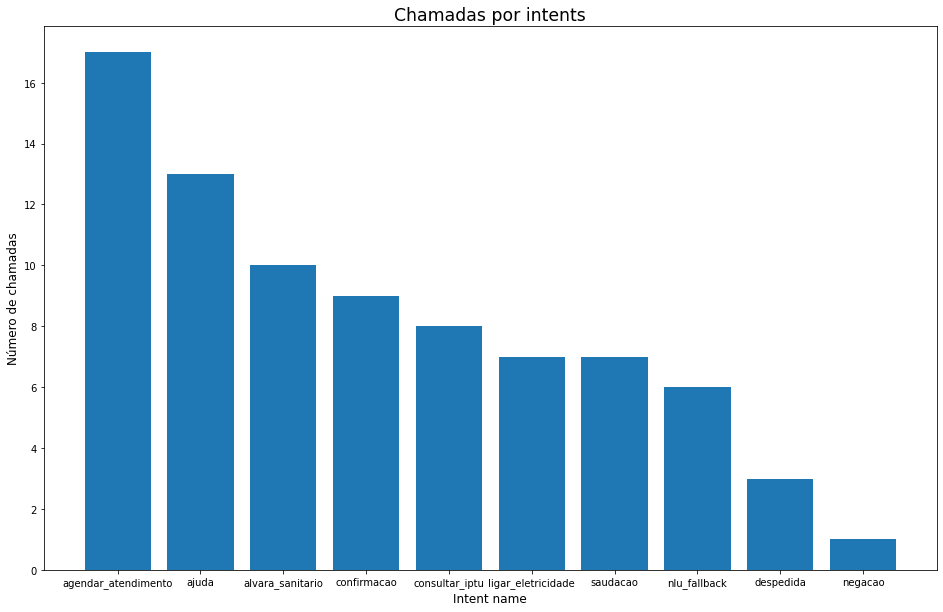

In [47]:
(fig, ax) = plt.subplots(1, 1, figsize=(16, 10))

counts = df.intent_name.value_counts()
ax.bar(counts.index, counts)
ax.set_title('Chamadas por intents', fontsize='xx-large')
ax.set_xlabel('Intent name', fontsize='large')
ax.set_ylabel('Número de chamadas',fontsize='large')
plt.show()

Acima é possível observar os serviços mais utilizados pelos usuários do ponto de vista geral (valores absolutos).

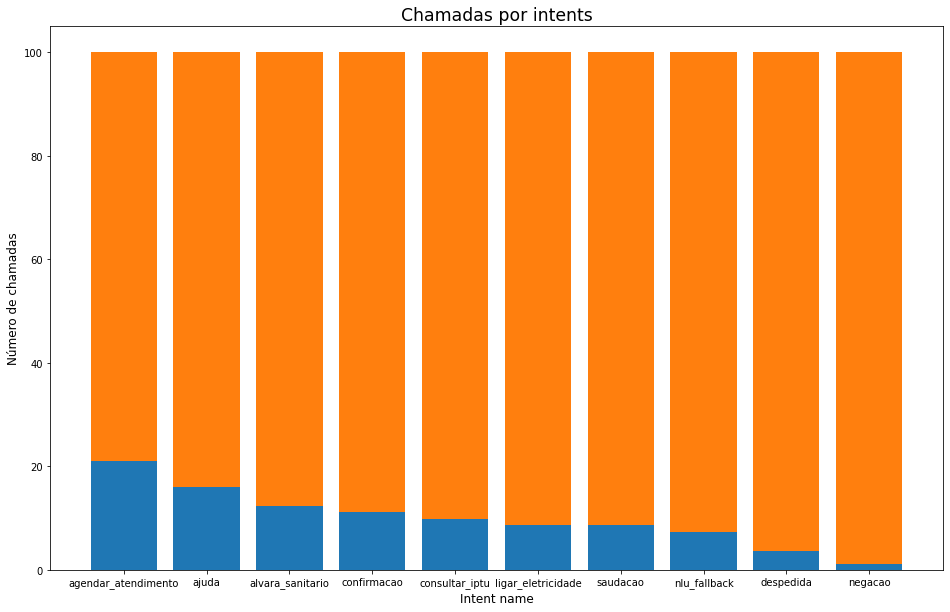

In [83]:
intent_total = df.intent_name.value_counts().values.sum()

(fig, ax) = plt.subplots(1, 1, figsize=(16, 10))

counts_percent = df.intent_name.value_counts() / intent_total * 100
ax.bar(counts.index, counts_percent, bottom=0)
ax.bar(counts.index, 100 - counts_percent, bottom=counts_percent)

ax.set_title('Chamadas por intents', fontsize='xx-large')
ax.set_xlabel('Intent name', fontsize='large')
ax.set_ylabel('% de chamadas',fontsize='large')
plt.show()

Agora, é possível observar este mesmo indicador, mas em relação ao total de mensagens dos usuários (valores relativos - em %).

## Taxa de transbordo

Ainda através do gráfico anterior, observa-se que o serviço mais utilizado pelos usuários é o de agendamento de atendimento. Este serviço, sob determinado ponto de vista, pode ser interpretado como a taxa de transbordo, uma vez que o bot não foi capaz de solucionar por completo a necessidade do usuário e precisou redirecionar o usuário para um atendimento humano/ presencial.

Abaixo este indicador foi isolado para melhor representação numérica

In [134]:
total_agendamento = df[df.intent_name == 'agendar_atendimento'].intent_name.count()
taxa_transbordo = total_agendamento / intent_total * 100
print(f'A taxa total de transbordo é de aproximadamente{taxa_transbordo: .2f}%.')

A taxa total de transbordo é de aproximadamente 20.99%.


## Taxa de fallback

Sempre que o bot não é capaz de entender a mensagem enviada pelo usuário em determinado contexto com um percentual mínimo de segurança, ocorre o chamado *fallback*.

Este indicador é representado pela intent ``nlu_fallback``, que também foi isolada abaixo para melhor visualização numérica.

In [135]:
total_nlu_fallback = df[df.intent_name == 'nlu_fallback'].intent_name.count()
taxa_fallback = total_nlu_fallback / intent_total * 100
print(f'A taxa total de fallback é de aproximadamente{taxa_fallback: .2f}%.')

A taxa total de fallback é de aproximadamente 7.41%.


Lembrando que o ideal é reduzir ao máximo o fallback, no sentido de aumentar a *percepção* do bot, porém lembrando que em determinados casos é melhor "não entender" determinado input do usuário, do que entendê-lo, porém errado.

## Taxa de confiança

A taxa de confiança indica o nível de *segurança* com qual o bot realizou a classificação da mensagem do usuário e agiu de acordo.

In [136]:
intent_mean_confidence = df['parse_data.intent.confidence'].mean()
taxa_confianca_intents = intent_mean_confidence * 100
print(f'A confiança média para classificação das intents é de{taxa_confianca_intents: .2f}%.')

A confiança média para classificação das intents é de 94.90%.


Porém, há ainda a taxa de confiança com a qual o bot prevê as ações internas. Ou seja, é o nível de *segurança* com o qual o bot age conforme as ações do usuário.

In [138]:
taxa_confianca_actions = df.confidence.mean() * 100
print(f'A confiança média para definição das actions é de{taxa_confianca_actions: .2f}%.')

A confiança média para definição das actions é de 91.79%.


In [140]:
print(f'A confiança total média do bot é de{(taxa_confianca_actions + taxa_confianca_intents) / 2: .2f}%')

A confiança total média do bot é de 93.35%


## Acurácia, precisão, recall e F1-score

In [175]:
df_confusion_matrix = pd.concat([df.intent_name, df['parse_data.text'], df['parse_data.intent.confidence']], axis=1)
df_confusion_matrix = df_confusion_matrix[df_confusion_matrix.intent_name.astype(str) != 'nan'].reset_index()
df_confusion_matrix.to_csv('data_test.csv')

In [176]:
#Os valores preditos são aqueles que o próprio modelo classificou
y_predicted = df_confusion_matrix.intent_name

#Os valores de teste (comparação) são aqueles que passaram pela etapa de curadoria
y_test = pd.read_csv('data_test.csv').intent_name

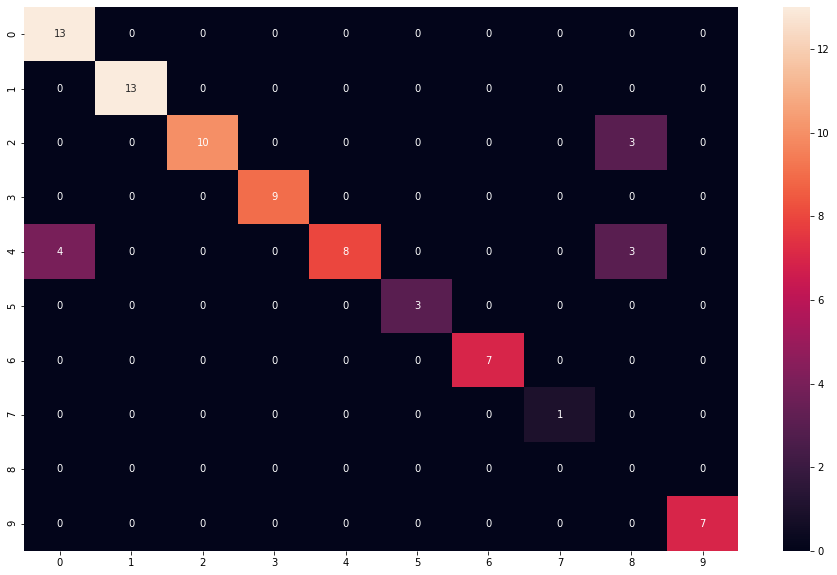

In [213]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_predicted)

import seaborn as sn
plt.figure(figsize = (16,10))
sn.heatmap(confusion, annot=True)

In [204]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Acurácia: {accuracy_score(y_test, y_predicted) * 100:.2f}%.')
micro_precision = precision_score(y_test, y_predicted, average='micro')
print(f'Micro Precision: {micro_precision * 100:.2f}%.')
micro_recall = recall_score(y_test, y_predicted, average='micro')
print(f'Micro Recall: {micro_recall * 100:.2f}%.')
micro_f1score = f1_score(y_test, y_predicted, average='micro')
print(f'Micro F1-score: {micro_f1score * 100:.2f}%')
macro_precision = precision_score(y_test, y_predicted, average='macro')
print(f'Macro Precision: {macro_precision * 100:.2f}%.')
macro_recall = recall_score(y_test, y_predicted, average='macro')
print(f'Macro Recall: {macro_recall * 100:.2f}%.')
macro_f1score = f1_score(y_test, y_predicted, average='macro')
print(f'Macro F1-score: {macro_f1score * 100:.2f}%')

weighted_precision = precision_score(y_test, y_predicted, average='weighted')
print(f'Weighted Precision: {weighted_precision * 100:.2f}%.')
weighted_recall = recall_score(y_test, y_predicted, average='weighted')
print(f'Weighted Recall: {weighted_recall * 100:.2f}%.')
weighted_f1score = f1_score(y_test, y_predicted, average='weighted')
print(f'Weighted F1-score: {weighted_f1score * 100:.2f}%')

Acurácia: 87.65%.
Micro Precision: 87.65%.
Micro Recall: 87.65%.
Micro F1-score: 87.65%
Macro Precision: 87.65%.
Macro Recall: 83.03%.
Macro F1-score: 84.32%
Weighted Precision: 96.22%.
Weighted Recall: 87.65%.
Weighted F1-score: 90.13%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Alocação interna do bot

Uma vez que o bot está em execução e o usuário abre a janela para interação com o mesmo, o processamento do bot já está sendo realizado. A seguir podemos observar a alocação do tempo do bot.

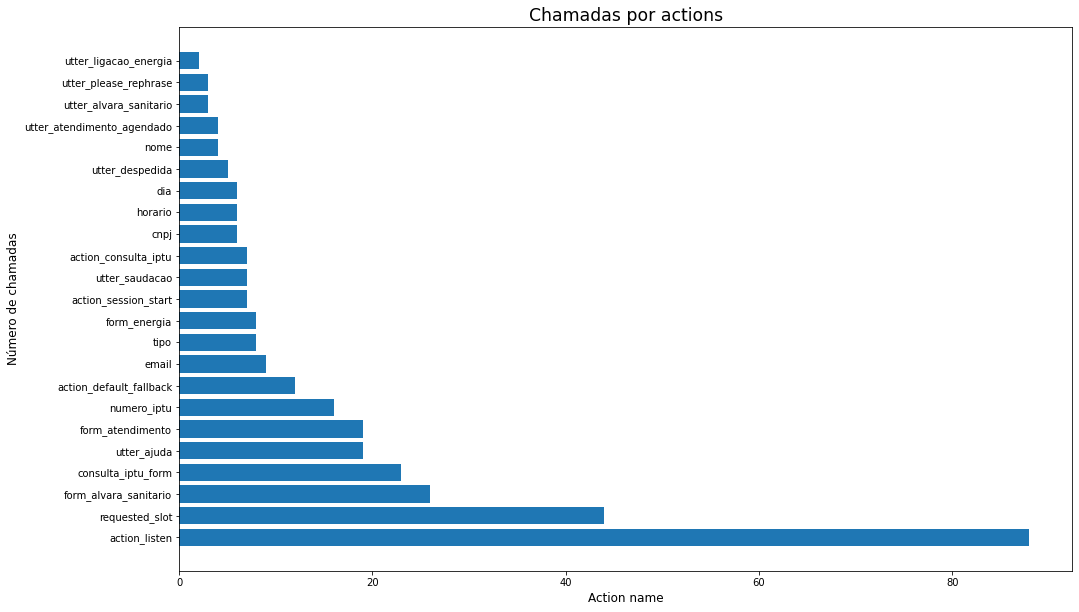

In [39]:
(fig, ax) = plt.subplots(1, 1, figsize=(16, 10))

counts = df.action_name.value_counts()
ax.barh(counts.index, counts)
ax.set_title('Chamadas por actions', fontsize='xx-large')
ax.set_xlabel('Action name', fontsize='large')
ax.set_ylabel('Número de chamadas',fontsize='large')
plt.show()

A atenção especial neste caso vai ao "tempo ocioso", representado pela *action* ``action_listen``, ou seja, é a quantidade de vezes que o bot fica aguardando alguma mensagem do usuário.